In [28]:
from vivit import run_experiment, test_files, classes
from data import get_video_label, VideoDataGenerator, labels_df, files, labels, num_to_label, files
from synthetic import *
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import synthetic

In [4]:
classes = list(labels_df.groupby('label').size().sort_values(ascending=False)[:10].index)
good_classes = ['book', "drink", "go", "chair", "who", "clothes", "yes", "year", "thin", "fine"]
test_files = [f for f in files if labels[int(os.path.basename(f).split('.')[0])] in good_classes]
base = "../data/videos"
for video, f in enumerate(test_files):
    name = os.path.basename(f)
    if not os.path.exists(f"{base}/flipped/{name}"):
        synthetic.flip_video(f"{base}/original/{name}", f"{base}/flipped/{name}")
    if not os.path.exists(f"{base}/rotated_90/{name}"):
        synthetic.rotate_video(f"{base}/original/{name}", f"{base}/rotated_90/{name}", 90)
    if not os.path.exists(f"{base}/rotated_270/{name}"):
        synthetic.rotate_video(f"{base}/original/{name}", f"{base}/rotated_270/{name}", 270)
    if not os.path.exists(f"{base}/noised/{name}"):
        synthetic.noise_video(f"{base}/original/{name}", f"{base}/noised/{name}")
    print(f"{video+1}/{len(test_files)}", end = '\r')
all_files = []
for folder in ["original", "flipped", "rotated_90", "rotated_270", "noised"]:
    all_files += [f"{base}/{folder}/{os.path.basename(f)}" for f in test_files]
y = [get_video_label(f) for f in all_files]
X_train, X_test, y_train, y_test = train_test_split(all_files, y, test_size=0.2, random_state=42, stratify=y)
train, validation = VideoDataGenerator(X_train), VideoDataGenerator(X_test)

In [8]:
model = keras.models.load_model("../models/high-epoch.keras")

In [9]:
model.evaluate(validation, verbose=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 600ms/step - accuracy: 0.8167 - loss: 0.9964 - top-5-accuracy: 0.9535


[1.0455151796340942, 0.796226441860199, 0.9547169804573059]

In [10]:
# make predictions on the testing set
preds = model.predict(validation, verbose=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 678ms/step


In [30]:
labels = [num_to_label[p] for p in np.argmax(preds, axis=1)]
true_labels = [num_to_label[p] for p in y_test]
predictions = pd.DataFrame({"true": true_labels, "predicted": labels})
predictions["correct"] = predictions["true"] == predictions["predicted"]
predictions["confidence"] = [preds[i][np.argmax(preds[i])] for i in range(len(preds))]

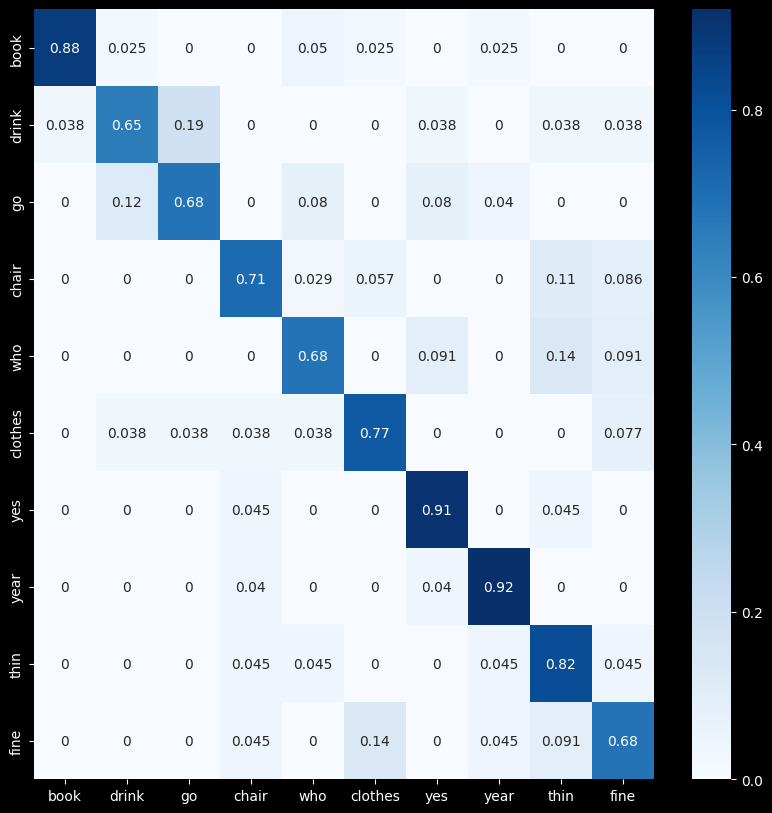

In [43]:
cm = confusion_matrix(true_labels, labels, normalize='true')
# make seaborn heatmap
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, xticklabels=good_classes, yticklabels=good_classes, cmap='Blues');